In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import PIL
from PIL import UnidentifiedImageError
from IPython.display import HTML
import cv2

# visualization libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

#from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-07-08 16:40:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-08 16:40:38 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread (optional for reproducibility)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Ensure reproducibility with TensorFlow 2.x
    tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Call the function to apply the seed settings
seed_everything()

# DATA

## View

In [ ]:
cd /content/drive/MyDrive/SU25QN23/Dataset/dataset_0607

/content/drive/.shortcut-targets-by-id/1mmXHs31P-v8kwRv6GjoeEWZyhJmIVjyb/SU25QN23/Dataset/dataset_0607


In [ ]:
unzip_data('dataset.zip')

In [ ]:
cd dataset
os.listdir()

['ape',
 'bat',
 'bee',
 'bird',
 'buffalo',
 'butterfly',
 'carp',
 'cat',
 'chicken',
 'chipmunk',
 'cow',
 'dog',
 'dove',
 'duck',
 'eagle',
 'elephant',
 'fish',
 'frog',
 'horse',
 'jelly_fish',
 'lion',
 'lobster',
 'mouse',
 'panther',
 'peacock',
 'pig',
 'rabbit',
 'seal',
 'snake',
 'spider',
 'starfish',
 'tiger',
 'turtle',
 'zebra']

In [ ]:
!cd /content

In [ ]:
data_dir="/content/drive/MyDrive/SU25QN23/Dataset/dataset_0607/dataset"

In [ ]:
all_class=os.listdir(data_dir)
folder_count = 0
try:
    for item_name in all_class:
        item_path = os.path.join(data_dir, item_name)
        if os.path.isdir(item_path):
            folder_count += 1

    print(f"{folder_count} class ")
except FileNotFoundError:
    print(f"Không tìm thấy đường dẫn: {data_dir}")

all_class

34 class 


['ape',
 'bat',
 'bee',
 'bird',
 'buffalo',
 'butterfly',
 'carp',
 'cat',
 'chicken',
 'chipmunk',
 'cow',
 'dog',
 'dove',
 'duck',
 'eagle',
 'elephant',
 'fish',
 'frog',
 'horse',
 'jelly_fish',
 'lion',
 'lobster',
 'mouse',
 'panther',
 'peacock',
 'pig',
 'rabbit',
 'seal',
 'snake',
 'spider',
 'starfish',
 'tiger',
 'turtle',
 'zebra']

## Train Test Splitting and Data Generator

In [ ]:
def create_image_df(dataset_dir):
    """
    Tạo DataFrame từ đường dẫn ảnh
    """
    image_dir = Path(dataset_dir)

    # 1. Tìm tất cả các file ảnh trong một lần lặp
    extensions = ['**/*.jpg', '**/*.JPG', '**/*.png', '**/*.PNG']
    filepaths = []
    for ext in extensions:
        filepaths.extend(image_dir.glob(ext))

    # 2. Lấy nhãn bằng phương thức của Path
    labels = [path.parent.name for path in filepaths]

    # Tạo DataFrame
    image_df = pd.DataFrame({
        'Filepath': [str(p) for p in filepaths], # Chuyển Path object thành string
        'Label': labels
    })

    return image_df

image_df = create_image_df(data_dir)

In [ ]:
print(image_df['Label'].value_counts())

Label
bat           1000
bee           1000
zebra         1000
bird          1000
buffalo       1000
butterfly     1000
carp          1000
cat           1000
chicken       1000
chipmunk      1000
cow           1000
dog           1000
dove          1000
duck          1000
eagle         1000
elephant      1000
frog          1000
horse         1000
tiger         1000
lion          1000
mouse         1000
turtle        1000
starfish      1000
spider        1000
snake         1000
rabbit        1000
lobster        987
pig            962
peacock        919
ape            906
panther        900
fish           888
seal           881
jelly_fish     845
Name: count, dtype: int64


In [ ]:
label_counts = image_df['Label'].value_counts()
classes_to_remove = label_counts[label_counts < 10].index

# Tạo một DataFrame mới không chứa các lớp này
image_df = image_df[~image_df['Label'].isin(classes_to_remove)]

print("Các lớp đã bị loại bỏ vì có quá ít mẫu:", list(classes_to_remove),": ",classes_to_remove.value_counts())
print("Số lớp còn lại:", image_df['Label'].nunique())
print(image_df['Label'].value_counts())

Các lớp đã bị loại bỏ vì có quá ít mẫu: [] :  Series([], Name: count, dtype: int64)
Số lớp còn lại: 34
Label
bat           1000
bee           1000
zebra         1000
bird          1000
buffalo       1000
butterfly     1000
carp          1000
cat           1000
chicken       1000
chipmunk      1000
cow           1000
dog           1000
dove          1000
duck          1000
eagle         1000
elephant      1000
frog          1000
horse         1000
tiger         1000
lion          1000
mouse         1000
turtle        1000
starfish      1000
spider        1000
snake         1000
rabbit        1000
lobster        987
pig            962
peacock        919
ape            906
panther        900
fish           888
seal           881
jelly_fish     845
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42,stratify=image_df['Label'])

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,  # Normalize images as required by EfficientNetV2
    validation_split=0.2  # Split 20% of the data for validation
)

# Create a separate ImageDataGenerator for the test set
# Applies the same preprocessing without any data augmentation or splitting

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input  # Ensure test data is preprocessed the same way
)

In [ ]:
target_size = (256, 256)
batch_size= 128

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size = target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size = target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 21304 validated image filenames belonging to 34 classes.
Found 5326 validated image filenames belonging to 34 classes.
Found 6658 validated image filenames belonging to 34 classes.


In [ ]:
# Data Augmentation Pipeline
# This sequential preprocessing layer applies transformations to training images on-the-fly
augment = tf.keras.Sequential([
    # Resize all input images to 224x224
    tf.keras.layers.Resizing(224, 224),

    # Normalize pixel values to the range [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # Randomly flip images horizontally (e.g., mirror images of insects)
    tf.keras.layers.RandomFlip("horizontal"),

    # Apply small random rotations (±10%) to improve rotation invariance
    tf.keras.layers.RandomRotation(0.1),

    # Apply slight random zoom to make the model more robust to scale changes
    tf.keras.layers.RandomZoom(0.1),

    # Randomly adjust image contrast to improve generalization to lighting conditions
    tf.keras.layers.RandomContrast(0.1),
])


# Modeling

Use CNN pre-train **EfficientNetV2M** known for its balance between accuracy and efficiency

3 callbacks are used to monitor and optimize performance:

ModelCheckpoint, EarlyStopping, and TensorBoard

Batch size: 32\
Epochs: 80\
Input Shape: (256, 256, 3)\
Output layer: 12

In [ ]:
# Load the pretrained EfficientNetV2M model from TensorFlow applications
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    input_shape=(256, 256, 3),  # Define the expected input image size
    include_top=False,          # Exclude the final classification layer (we'll add our own)
    weights='imagenet',         # Load pretrained weights from ImageNet
    pooling='max'               # Apply global max pooling after the last conv layer
)

# Freeze the base model so its weights won't be updated during training
# Only the custom classification head will be trainable
pretrained_model.trainable = False

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
# Create checkpoint callback with .weights.h5 extension
output_dir = "/content/drive/MyDrive/Colab Notebooks/SU25QN23/Modeling/EfficientNetV2M_output/data0607"
os.makedirs(os.path.dirname(output_dir), exist_ok=True)
tensorboard_log_dir = os.path.join(output_dir, "training_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
output_file_name = "Bio_classification_model_checkpoint.weights.h5"
model_filename = "full_bio_classification_model.keras"
checkpoint_path = os.path.join(output_dir, output_file_name)
model_save_path = os.path.join(output_dir, model_filename)



checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,  # Save only the weights, not the entire model
    monitor="val_accuracy",  # Monitor validation accuracy during training
    save_best_only=True  # Save only the best model weights based on validation accuracy
)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 7,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
NUM_CLASSES = image_df['Label'].nunique()
print(NUM_CLASSES)
print(image_df['Label'].value_counts())

34
Label
bat           1000
bee           1000
zebra         1000
bird          1000
buffalo       1000
butterfly     1000
carp          1000
cat           1000
chicken       1000
chipmunk      1000
cow           1000
dog           1000
dove          1000
duck          1000
eagle         1000
elephant      1000
frog          1000
horse         1000
tiger         1000
lion          1000
mouse         1000
turtle        1000
starfish      1000
spider        1000
snake         1000
rabbit        1000
lobster        987
pig            962
peacock        919
ape            906
panther        900
fish           888
seal           881
jelly_fish     845
Name: count, dtype: int64


In [ ]:
# Use the input layer from the pretrained base model
inputs = pretrained_model.input

# Apply data augmentation to the input images
x = augment(inputs)

# Add a dense layer with 128 units and ReLU activation on top of the pretrained model
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)  # Apply dropout for regularization to prevent overfitting

# Add another dense layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)  # Another dropout layer for robustness

# Final output layer with 12 units (for 12 classes) and softmax activation for multiclass classification
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the full model combining the pretrained base and custom head
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a low learning rate and appropriate loss and metric for classification
model.compile(
    optimizer=Adam(0.001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Monitor accuracy during training
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        648 │ rescaling_1[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 128, 128,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 128, 128,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 128, 128,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 128, 128,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 128, 128,  │      5,184 │ block1b_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 128, 128,  │         96 │ block1c_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 128, 128,  │          0 │ block1c_project_

 Total params: 53,356,118 (203.54 MB)

 Trainable params: 205,730 (803.63 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Train the model
history = model.fit(
    train_images,  # Training data
    validation_data=val_images,  # Validation data
    epochs=50,  # Total number of training epochs
    callbacks=[
        early_stopping,
        create_tensorboard_callback(tensorboard_log_dir, "classification"),  # Log training for TensorBoard
        checkpoint_callback,  # Save the best model weights during training
    ]
)

Saving TensorBoard log files to: /content/drive/MyDrive/Colab Notebooks/SU25QN23/Modeling/EfficientNetV2M_output/data0607/training_logs/classification/20250708-164205


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 58/167 ━━━━━━━━━━━━━━━━━━━━ 3:26:37 114s/step - accuracy: 0.0474 - loss: 4.1930

In [ ]:
model.save_weights('/content/drive/MyDrive/my_model_weights.h5')

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/drive/MyDrive/my_model_weights.h5

In [ ]:
print(model.input_shape)

## Test

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.14305
Test Accuracy: 94.90%


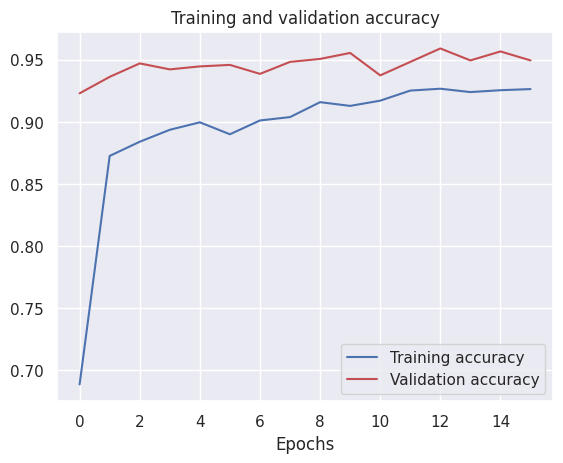

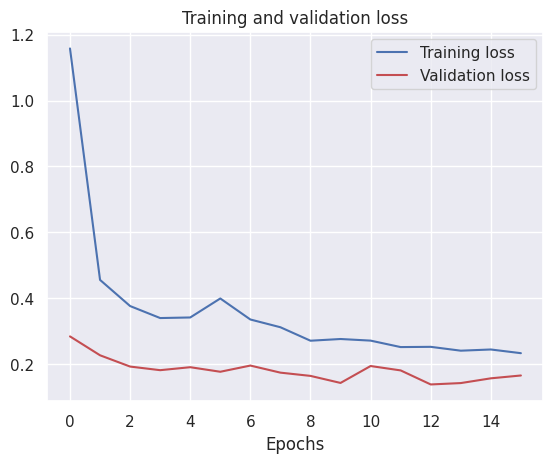

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 896ms/step
The first 5 predictions: ['ants', 'pea_plant', 'pea_plant', 'pea_plant', 'rice_plant']


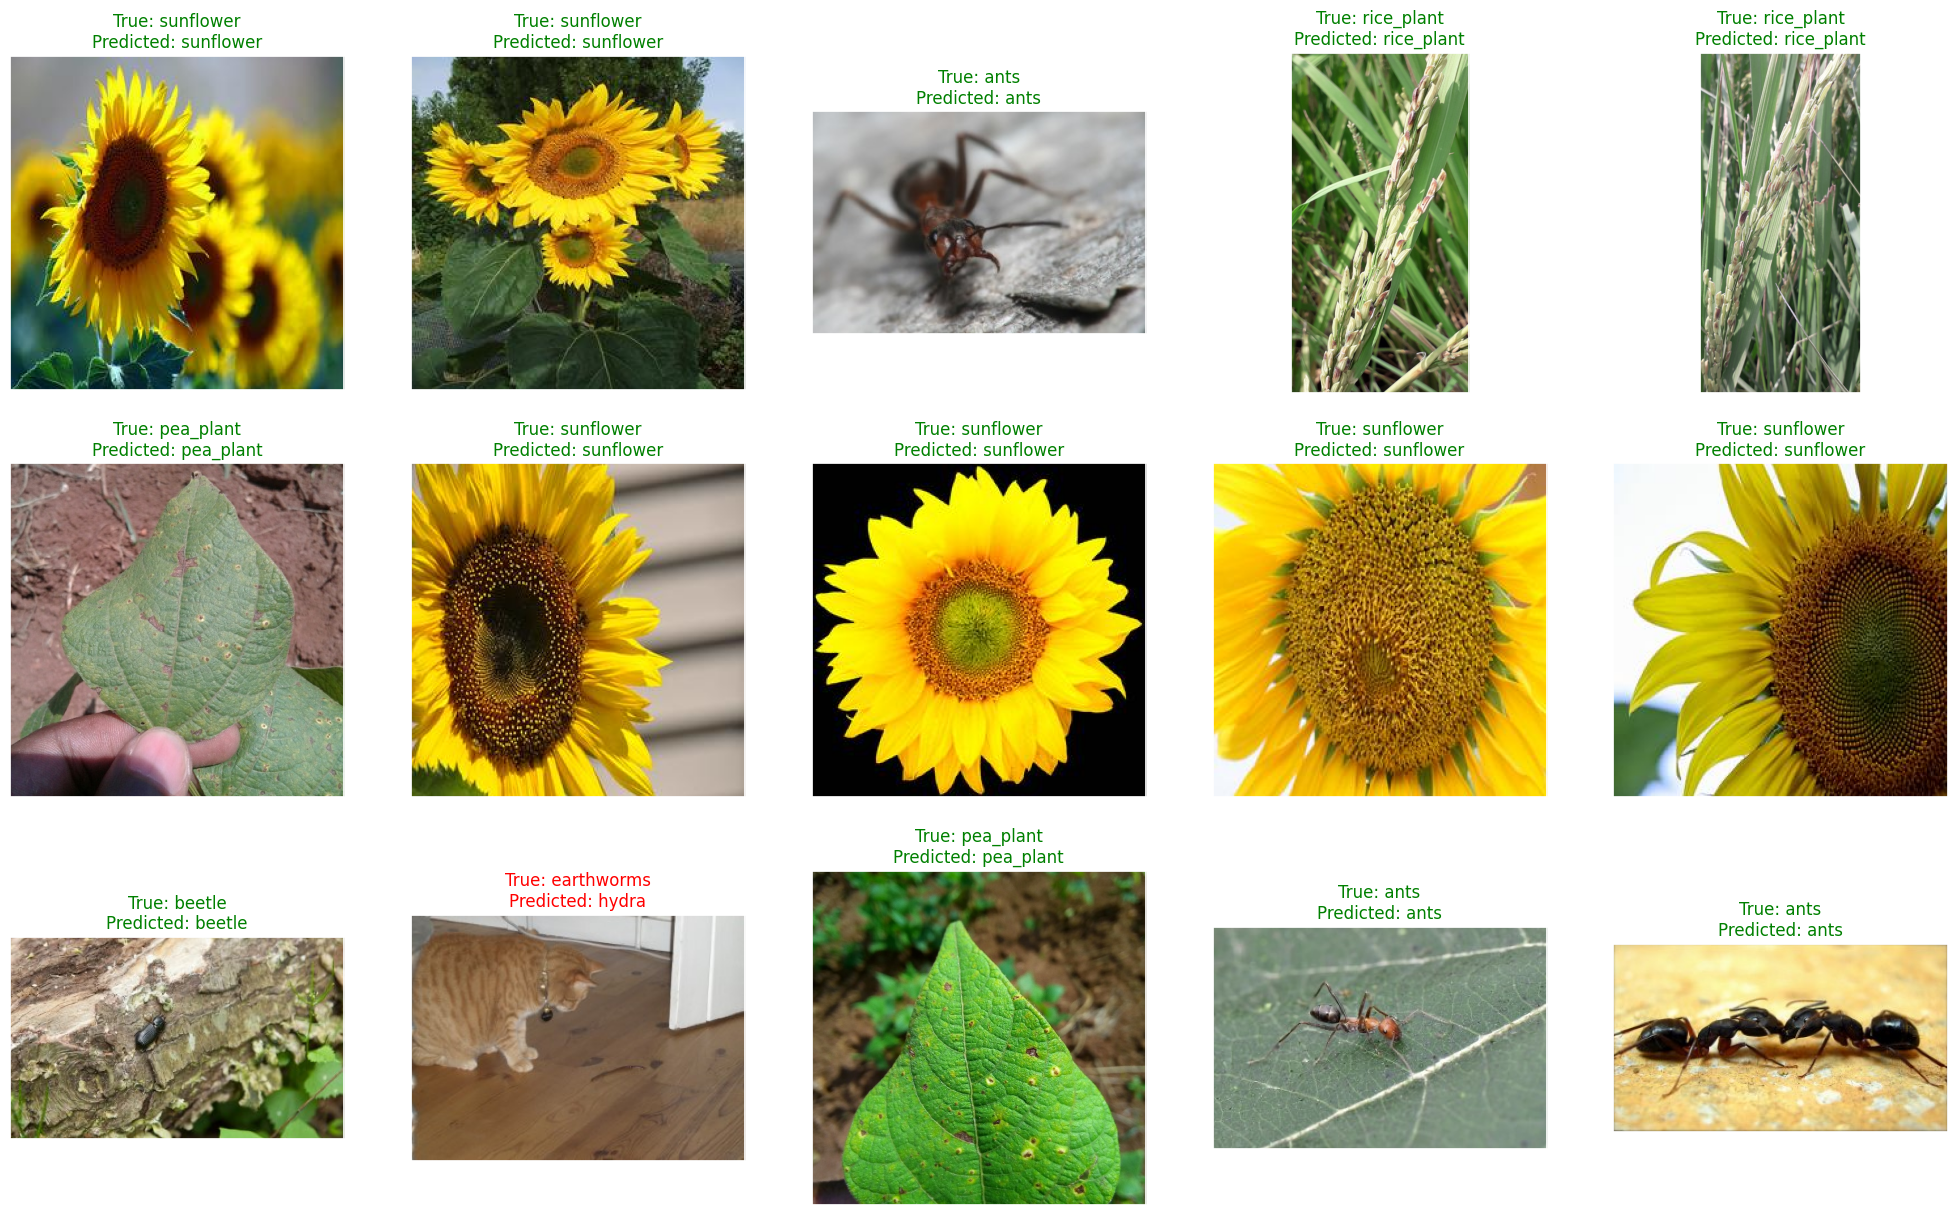

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()


## confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Coffee-plant       0.00      0.00      0.00         8
        ants       0.99      0.99      0.99       100
        bees       0.95      0.94      0.94        99
      beetle       0.86      0.89      0.87        81
  earthworms       0.71      0.88      0.79        65
       hydra       0.69      0.60      0.64        15
       maize       0.00      0.00      0.00         4
   pea_plant       0.99      0.98      0.98       259
  rice_plant       0.98      1.00      0.99       201
   sugarcane       0.00      0.00      0.00         4
   sunflower       1.00      1.00      1.00       204

    accuracy                           0.95      1040
   macro avg       0.65      0.66      0.65      1040
weighted avg       0.94      0.95      0.94      1040



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


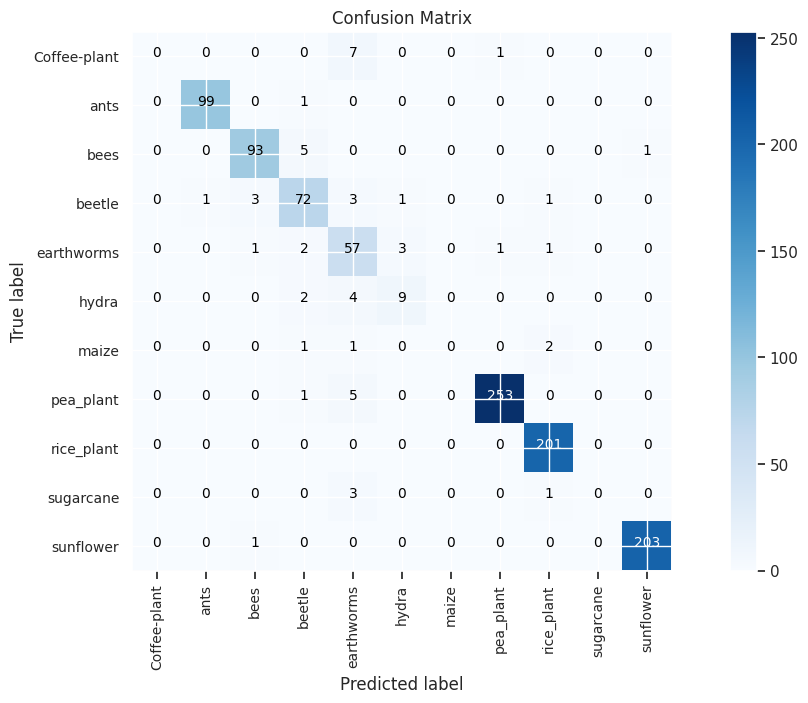

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_test, pred, list(labels.values()))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os

# --- PHẦN THIẾT LẬP CẦN CÓ TRONG BACKEND ---

# 1. Đường dẫn tới file model đã lưu
# Trong môi trường server, bạn sẽ đặt file model này ở một vị trí cố định
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SU25QN23/Modeling/EfficientNetV2M_output/Ver1_raw/full_bio_classification_model.keras"

# Dựa theo notebook của bạn, thứ tự có thể là:
CLASS_NAMES = ['Coffee-plant', 'Hydra', 'ants', 'bees', 'beetle', 'earthworms', 'maize', 'pea_plant', 'rice_plant', 'sugarcane', 'sunflower']

# 3. Tải mô hình một lần duy nhất khi backend khởi động
print(f"--- Đang tải mô hình từ {MODEL_PATH} ---")
try:
    model = load_model(MODEL_PATH)
    print("✅ Tải mô hình thành công, sẵn sàng dự đoán.")
except Exception as e:
    print(f"❌ Lỗi nghiêm trọng khi tải mô hình: {e}")
    model = None


--- Đang tải mô hình từ /content/drive/MyDrive/Colab Notebooks/SU25QN23/Modeling/EfficientNetV2M_output/Ver1_raw/full_bio_classification_model.keras ---
✅ Tải mô hình thành công, sẵn sàng dự đoán.


In [ ]:

# --- HÀM DỰ ĐOÁN ĐỂ GỌI MỖI KHI CÓ ẢNH MỚI ---
def predict_image(image_path):
    """
    Hàm nhận đường dẫn của một ảnh, tiền xử lý và trả về tên lớp dự đoán cùng độ tin cậy.
    """
    if model is None:
        return "Lỗi: Mô hình chưa được tải.", 0.0

    try:
        # a. Tải và tiền xử lý ảnh
        img = load_img(image_path, target_size=(256, 256))
        img_array = img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        preprocessed_img = tf.keras.applications.efficientnet_v2.preprocess_input(img_batch)

        # b. Dự đoán
        prediction_probs = model.predict(preprocessed_img)
        predicted_index = np.argmax(prediction_probs, axis=1)[0]

        # c. Lấy kết quả
        predicted_class_name = CLASS_NAMES[predicted_index]
        prediction_confidence = np.max(prediction_probs) * 100

        return predicted_class_name, prediction_confidence

    except Exception as e:
        return f"Lỗi khi xử lý ảnh: {e}", 0.0

if __name__ == '__main__':
    # Giả sử người dùng vừa tải lên một ảnh và nó được lưu tại 'temp_image.jpg'
    path_to_new_image = "/content/iStock_000063947343_Medium_4e1c882b-faf0-4487-b45b-c2b557d32442.webp" # Đây sẽ là đường dẫn file người dùng tải lên

    # Tạo một ảnh giả để test
    if not os.path.exists(path_to_new_image):
        dummy_image_data = np.random.randint(0, 255, size=(256, 256, 3), dtype=np.uint8)
        tf.keras.utils.save_img(path_to_new_image, dummy_image_data)
        print(f"\n(Đã tạo ảnh giả '{path_to_new_image}' để thực hiện ví dụ)")


    # Gọi hàm dự đoán
    label, confidence = predict_image(path_to_new_image)

    print("\n--- KẾT QUẢ DỰ ĐOÁN CHO ẢNH MỚI ---")
    print(f"Nhãn dự đoán: {label}")
    print(f"Độ tin cậy: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

--- KẾT QUẢ DỰ ĐOÁN CHO ẢNH MỚI ---
Nhãn dự đoán: beetle
Độ tin cậy: 20.59%
